<a href="https://colab.research.google.com/github/wahyudi0018/PCVK_Ganjil_2024/blob/main/DayNightTwilight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Langkah 1: Impor Library yang Diperlukan

Pertama, kita mengimpor library yang dibutuhkan untuk pemrosesan data, pembuatan model, dan evaluasi.

In [ ]:
import os
import kagglehub
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Langkah 2: Unduh Dataset DayNightV1

Di langkah ini, kita unduh dataset DayNightV1 yang berisi gambar yang akan digunakan untuk melatih model klasifikasi. Dataset ini memiliki tiga kategori: day (siang), night (malam), dan twilight (senja).

In [ ]:
# Unduh dataset
path = kagglehub.dataset_download("adnaneren/daynightv1")

# Tentukan lokasi dataset
dataset_path = '/root/.cache/kagglehub/datasets/adnaneren/daynightv1/versions/1/daynightv1'
TRAINING_DIR = os.path.join(dataset_path, 'train')
VALIDATION_DIR = os.path.join(dataset_path, 'valid')
TEST_DIR = os.path.join(dataset_path, 'test')

# Kategori klasifikasi
categories = ['day', 'night', 'twilight']

## Langkah 3: Visualisasi Distribusi Data
Kita akan menampilkan jumlah gambar untuk setiap kategori (day, night, twilight) di dataset pelatihan dan pengujian.

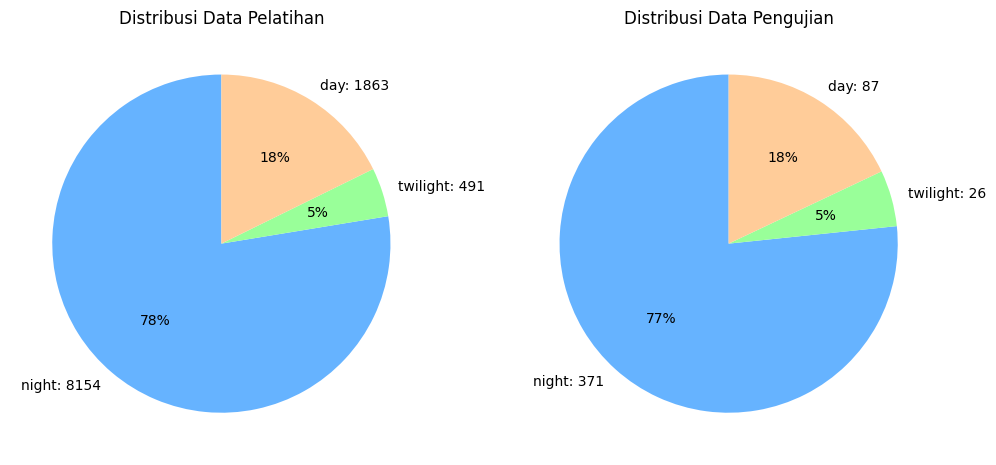

In [ ]:
# Fungsi untuk menghitung jumlah data dalam direktori
def get_class_counts(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Menghitung jumlah data pelatihan dan pengujian
train_counts = get_class_counts(TRAINING_DIR)
test_counts = get_class_counts(TEST_DIR)

# Fungsi untuk membuat label pie chart dengan jumlah gambar
def make_labels(counts):
    labels = [f'{label}: {count}' for label, count in counts.items()]
    return labels

# Visualisasi distribusi data pelatihan
plt.figure(figsize=(12, 6))

# Pie chart untuk data pelatihan
plt.subplot(1, 2, 1)
plt.pie(train_counts.values(), labels=make_labels(train_counts), autopct='%1.0f%%', startangle=90, colors=['#66b3ff','#99ff99','#ffcc99'])
plt.title('Distribusi Data Pelatihan')

# Pie chart untuk data pengujian
plt.subplot(1, 2, 2)
plt.pie(test_counts.values(), labels=make_labels(test_counts), autopct='%1.0f%%', startangle=90, colors=['#66b3ff','#99ff99','#ffcc99'])
plt.title('Distribusi Data Pengujian')

# Menampilkan plot
plt.show()

## Langkah 4: Menyiapkan Variabel Global

Di langkah ini, kita mendefinisikan variabel global seperti ukuran gambar, batch size, jumlah epoch, dan seed untuk keperluan reproduktifitas eksperimen.

In [ ]:
# Parameter untuk pelatihan
image_size = (150, 150)
batch_size = 32
epochs = 15
SEED = 111
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

## Langkah 5: Preprocessing Data

Untuk mempersiapkan data latih, kita menggunakan ImageDataGenerator untuk melakukan augmentasi gambar pada data latih. Hal ini bertujuan untuk meningkatkan jumlah dan variasi data latih tanpa menambah ukuran dataset secara fisik.

In [ ]:
# Preprocessing data latih
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi piksel gambar
    rotation_range=10,
    brightness_range=(0.85, 1.15),
    width_shift_range=0.002,
    height_shift_range=0.002,
    shear_range=12.5,
    zoom_range=0,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest"
)

# Generator data latih
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",  # Klasifikasi multi-kelas
    seed=SEED
)

# Preprocessing data uji
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator data uji
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",  # Klasifikasi multi-kelas
    shuffle=False,  # Tidak diacak untuk evaluasi
    seed=SEED
)

Found 10508 images belonging to 3 classes.
Found 484 images belonging to 3 classes.


## Langkah 6: Mendefinisikan Model CNN

Pada langkah ini, kita membangun model CNN (Convolutional Neural Network) dengan beberapa lapisan konvolusional diikuti oleh lapisan pooling dan akhirnya lapisan fully connected. Kita juga menambahkan Dropout untuk mengurangi overfitting.

In [ ]:
# Mendefinisikan bentuk gambar input
image_shape = (image_size[0], image_size[1], 3)

# Definisi model CNN
model = models.Sequential([
    # Lapisan konvolusi pertama
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(3, 3)),

    # Lapisan konvolusi kedua
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Lapisan konvolusi ketiga
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Lapisan konvolusi keempat
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),  # Meratakan output untuk lapisan fully connected

    # Lapisan fully connected dengan Dropout
    Dense(512, activation="relu"),
    Dropout(0.6, seed=SEED),  # Meningkatkan dropout untuk mengurangi overfitting
    Dense(len(categories), activation="softmax")  # Output layer (jumlah kategori)
])

# Menampilkan ringkasan model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 147, 147, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       131200    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

## Langkah 7: Menyusun Model

Di sini, kita menyusun model dengan memilih optimizer Adam, fungsi loss categorical_crossentropy, dan metrik akurasi.

In [ ]:
# Menyusun model
optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

## Langkah 8: Menambahkan Callback

Untuk mencegah overfitting dan mempercepat konvergensi, kita menambahkan dua callback: EarlyStopping untuk menghentikan pelatihan jika tidak ada peningkatan pada validasi dan ReduceLROnPlateau untuk mengurangi learning rate jika model berhenti membaik.

In [ ]:
# Callback untuk EarlyStopping dan ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-9, patience=5, verbose=True, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=True)

## Langkah 9: Melatih Model

Pada langkah ini, kita melatih model menggunakan generator data latih dan data uji, sambil memonitor akurasi dan loss selama pelatihan.

In [ ]:
# Melatih model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/15
328/328 [==============================] - 244s 742ms/step - loss: 0.2233 - accuracy: 0.9219 - val_loss: 0.1633 - val_accuracy: 0.9354 - lr: 0.0010
Epoch 2/15
328/328 [==============================] - 242s 738ms/step - loss: 0.1554 - accuracy: 0.9423 - val_loss: 0.1426 - val_accuracy: 0.9479 - lr: 0.0010
Epoch 3/15
328/328 [==============================] - 240s 731ms/step - loss: 0.1217 - accuracy: 0.9552 - val_loss: 0.1766 - val_accuracy: 0.9479 - lr: 0.0010
Epoch 4/15
328/328 [==============================] - 237s 722ms/step - loss: 0.0936 - accuracy: 0.9654 - val_loss: 0.1289 - val_accuracy: 0.9479 - lr: 0.0010
Epoch 5/15
328/328 [==============================] - 241s 735ms/step - loss: 0.0804 - accuracy: 0.9695 - val_loss: 0.1608 - val_accuracy: 0.9542 - lr: 0.0010
Epoch 6/15
328/328 [==============================] - 239s 727ms/step - loss: 0.0768 - accuracy: 0.9724 - val_loss: 0.1429 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 7/15
328/328 [==========================

## Langkah 10: Evaluasi Model

Setelah pelatihan selesai, kita mengevaluasi kinerja model pada data uji untuk melihat akurasi dan loss-nya.

In [ ]:
# Evaluasi model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

15/15 [==============================] - 3s 208ms/step - loss: 0.1274 - accuracy: 0.9708
Test Loss: 0.12742
Test Accuracy: 0.97083


## Langkah 11: Menyimpan Model
Model yang telah dilatih disimpan untuk digunakan kembali di masa depan.

In [ ]:
# Menyimpan model
model.save("daynighttwilight_model.keras")
print("Model telah disimpan sebagai 'daynighttwilight_model.keras'")

Model telah disimpan sebagai 'daynighttwilight_model.keras'


## Langkah 12: Plot Akurasi dan Loss

Untuk menganalisis kinerja model, kita dapat memvisualisasikan perubahan akurasi dan loss selama pelatihan dan validasi.

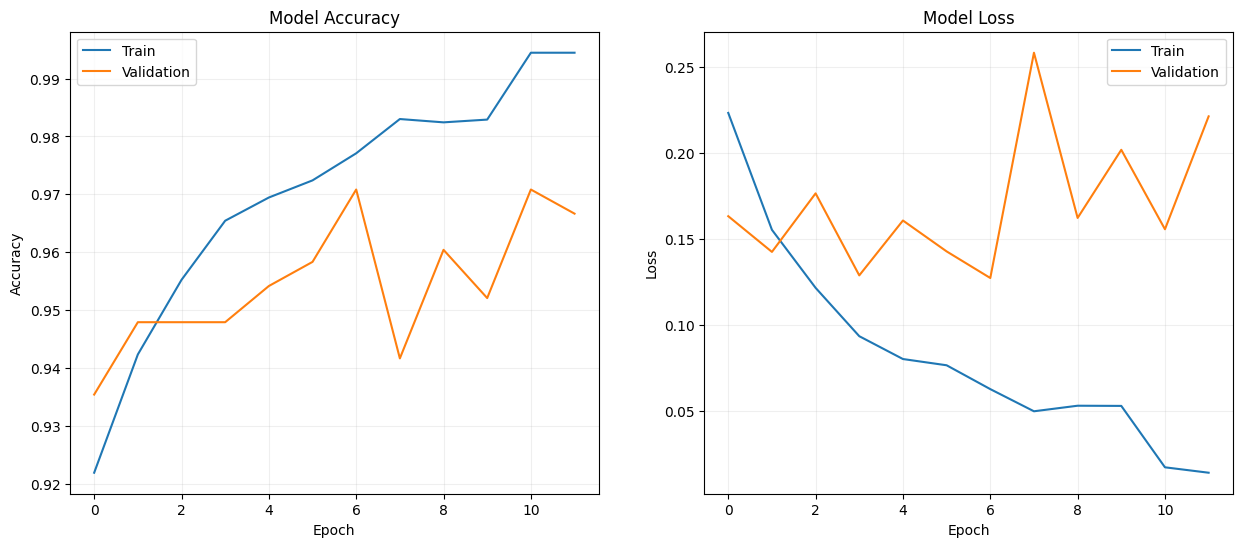

In [ ]:
# Plot Akurasi dan Loss
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot Akurasi
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

## Langkah 13: Confusion Matrix dan Classification Report

Akhirnya, kita dapat menghitung dan memvisualisasikan Confusion Matrix untuk mengevaluasi bagaimana model kita mengklasifikasikan setiap kategori dan menghitung metrik klasifikasi seperti precision, recall, dan f1-score.

16/16 [==============================] - 3s 213ms/step


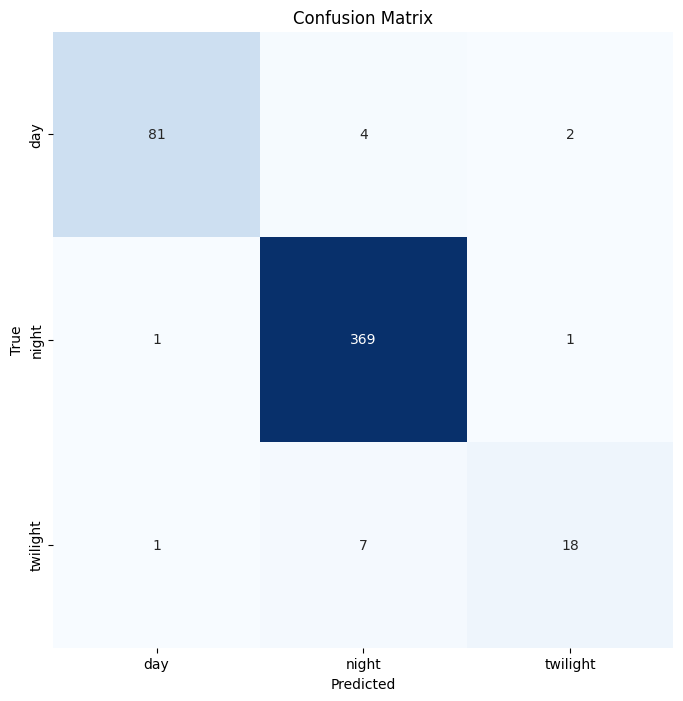

              precision    recall  f1-score   support

         day       0.98      0.93      0.95        87
       night       0.97      0.99      0.98       371
    twilight       0.86      0.69      0.77        26

    accuracy                           0.97       484
   macro avg       0.93      0.87      0.90       484
weighted avg       0.97      0.97      0.97       484



In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

# Prediksi dan konversi hasil prediksi ke kelas
y_true = test_generator.classes
y_pred = model.predict(test_generator, steps=np.ceil(test_generator.samples / batch_size), verbose=1)

# Pastikan hasil prediksi memiliki panjang yang sesuai dengan y_true
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)) + 0.5, labels=categories, ha='center')
plt.yticks(ticks=np.arange(len(categories)) + 0.5, labels=categories, va='center')
plt.show()

# Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=categories))

## Langkah 14: Prediksi Gambar Acak dan Visualisasi Hasil

Pada langkah ini, kita akan memilih 9 gambar secara acak dari dataset uji dan memprediksi kelasnya menggunakan model yang telah dilatih. Gambar-gambar tersebut akan ditampilkan dalam grid 3x3, di mana judul setiap gambar menunjukkan apakah prediksi model benar (berwarna hijau) atau salah (berwarna merah). Langkah ini bertujuan untuk memberikan gambaran visual tentang performa model dalam mengklasifikasikan gambar secara acak.

1/1 [==============================] - 0s 27ms/step


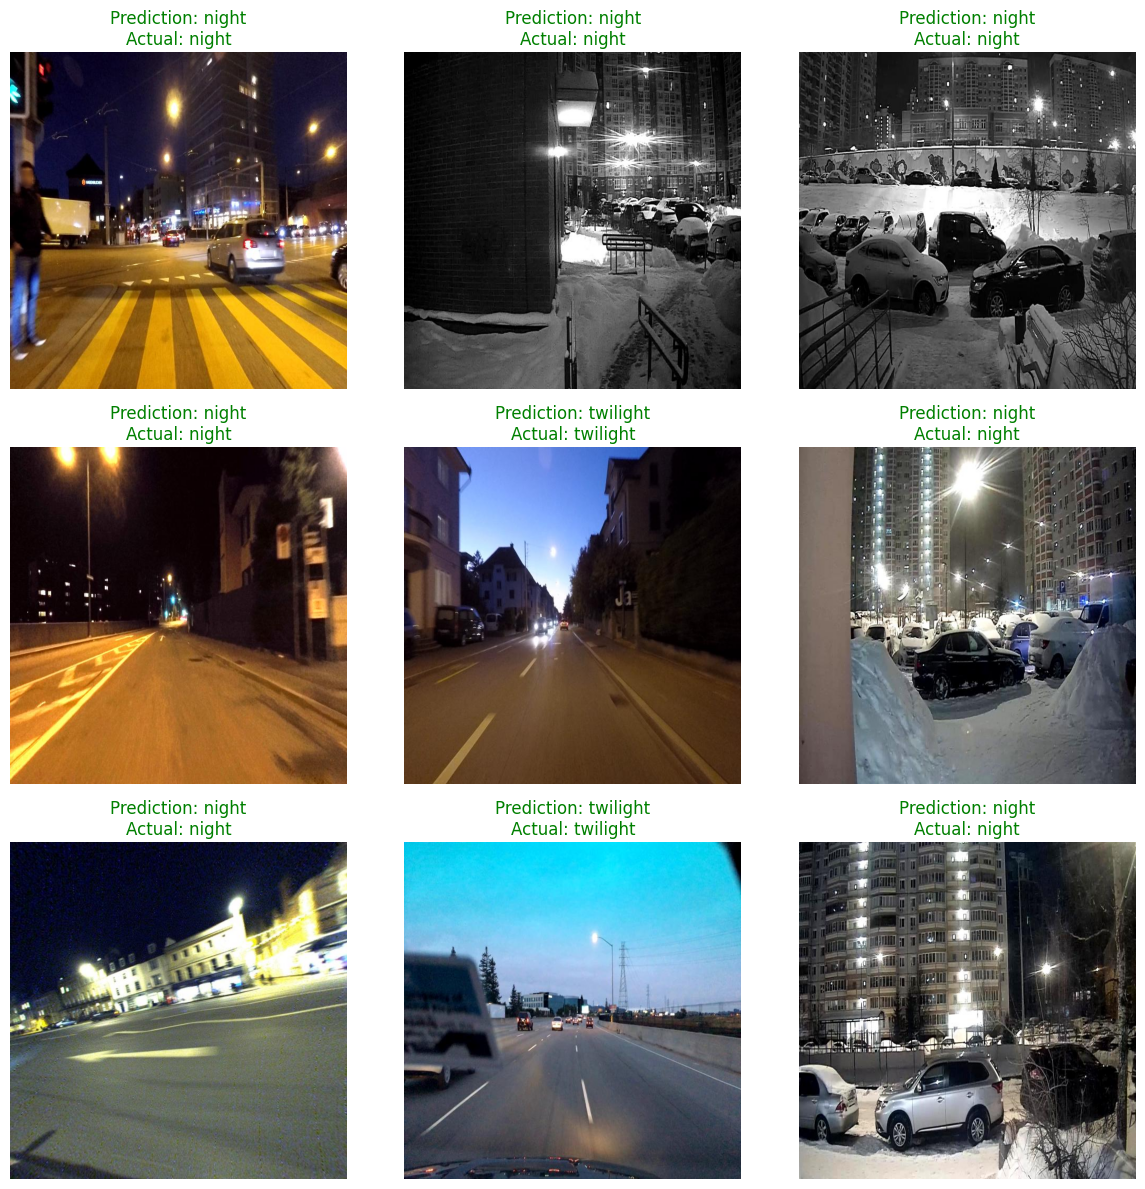

In [ ]:
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image

# Memuat model yang telah dilatih dari file yang disimpan
cnn = load_model("daynighttwilight_model.keras")  # Pastikan file model berada di path yang benar

# Fungsi untuk membuat prediksi pada gambar uji
def predictor(location):
    # Memuat dan memproses gambar
    test_image = image.load_img(location, target_size=(150, 150))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)

    # Melakukan prediksi dengan model yang telah dilatih
    result = cnn.predict(test_image)

    # Mendapatkan label kelas (day, night, twilight)
    class_labels = ['day', 'night', 'twilight']

    # Menemukan kelas dengan probabilitas prediksi tertinggi
    predicted_class = class_labels[np.argmax(result)]

    return predicted_class

# Langkah 1: Menyusuri subdirektori dan mengumpulkan file gambar yang valid
valid_image_extensions = ('.jpg', '.jpeg', '.png')

# Mendapatkan daftar file gambar dari subdirektori dalam TEST_DIR
test_images = []
test_labels = []  # Menyimpan label asli
TEST_DIR = "/root/.cache/kagglehub/datasets/adnaneren/daynightv1/versions/1/daynightv1/test"

for subdir in os.listdir(TEST_DIR):
    subdir_path = os.path.join(TEST_DIR, subdir)

    # Memastikan itu adalah direktori
    if os.path.isdir(subdir_path):
        # Mengumpulkan file gambar dari subdirektori
        for file in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, file)

            # Memeriksa apakah file tersebut adalah gambar
            if os.path.isfile(file_path) and file.endswith(valid_image_extensions):
                test_images.append(file_path)
                test_labels.append(subdir)  # Nama subdirektori adalah label asli

# Langkah 2: Jika daftar gambar kosong, tangani kesalahan
if len(test_images) == 0:
    print("Error: Tidak ada file gambar valid yang ditemukan di TEST_DIR.")
else:
    # Langkah 3: Memprediksi beberapa gambar acak dan membandingkannya dengan label asli
    predictions = []
    actual_labels = []
    num_samples = 9  # Jumlah gambar acak yang akan diprediksi

    # Memilih gambar acak dan membuat prediksi
    random_images = random.sample(test_images, num_samples)  # Memilih 9 gambar secara acak

    # Membuat plot dengan 3 baris dan 3 kolom (grid 3x3)
    plt.figure(figsize=(12, 12))

    for i, random_image in enumerate(random_images):
        # Mendapatkan label asli (nama subdirektori)
        actual_label = test_labels[test_images.index(random_image)]

        # Mendapatkan prediksi
        predicted_label = predictor(random_image)

        # Menyimpan prediksi dan label asli
        predictions.append(predicted_label)
        actual_labels.append(actual_label)

        # Menampilkan gambar
        img = Image.open(random_image)

        plt.subplot(3, 3, i+1)  # Membuat grid 3x3
        plt.imshow(img)

        # Mengatur judul berdasarkan apakah prediksi benar atau tidak
        if predicted_label == actual_label:
            plt.title(f'Prediction: {predicted_label}\nActual: {actual_label}', color='green')  # Prediksi benar, teks hijau
        else:
            plt.title(f'Prediction: {predicted_label}\nActual: {actual_label}', color='red')  # Prediksi salah, teks merah

        plt.axis('off')  # Menyembunyikan sumbu

    # Menyesuaikan tata letak agar tampilan lebih rapi
    plt.tight_layout()
    plt.show()